In [95]:
%load_ext autoreload
%autoreload 

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import shared.query as q
import shared.viz as viz

from scipy import sparse
from sklearn.metrics import pairwise_distances

viz.set_style()
conn = q.connect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Recommendations

This worksheet explores the inner workings of the core of the project - transforming reviews into recommendations

In [59]:
## Settings

review_quality_cutoff = None
review_sample_size = None # simulate a product with any number of reviews by picking this many subsamples
max_product_pool_size = 20
max_user_pool_size = 20
fill_value = 0


In [60]:
product = q.find_products('Books', search_term = 'Homage to Catalonia', conn = conn).loc[0]
product

find_products: 2 results in 1.676 seconds


id                                         0786102985
reviews                                           154
title           Homage to Catalonia (Library Edition)
creator                                           nan
publisher                                        None
description                                      None
release_date                                     None
category                                        Books
subcategory                                       nan
Name: 0, dtype: object

In [ ]:
def plot_user_ratings_by_product(
        data: pd.DataFrame, 
        target_product_id: str, # to highlight the active / target product 
        conn, 
        ax = None, 
        product_name_limit = 20,
        hide_y_axis_cutoff = 50,
        hide_x_axis_cutoff = 500
):    
    ax = ax or plt.gca()

    cmap = mpl.colormaps.get_cmap('Blues')
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    ax = sns.heatmap(data, vmin = 0, vmax = 5, cmap = cmap, norm = norm)

    colorbar = ax.collections[0].colorbar
    colorbar.set_label("Rating", fontsize = 15)
    colorbar.set_ticks(range(0,6))
    colorbar.set_ticklabels(['None', '★', '★★', '★★★', '★★★★', '★★★★★'], fontsize = 15)
    colorbar.outline.set_visible(True)
    colorbar.outline.set_color('k')
    print(dir(colorbar))

    product_names = q.get_product_details(data.index, conn = conn, select = 'title')['title']
    product_names = product_names.map(lambda title: title[:product_name_limit])
    ax.yaxis.set_ticklabels(product_names.values)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.set_label_text('User')
    ax.xaxis.set_ticklabels([''] * len(ax.xaxis.get_major_ticks()))

    if data.shape[1] >= hide_x_axis_cutoff:    
        ax.xaxis.set_visible(False)
    if data.shape[0] >= hide_y_axis_cutoff:
        ax.yaxis.set_visible(False)

## Get Related Reviews

Get all books that have reviewers in common with this book:

In [103]:
reviews = q.get_reviews(product.id, conn)
related_reviews = q.get_related_reviews(reviews, conn, filter_unhelpful_reviews = True, max_reviewer_count = max_user_pool_size, max_product_count = max_product_pool_size)


#related_reviews = q.get_records_by_ids(
#    ids = reviews.user_id.dropna().unique(), 
#    select = 'user_id, product_id, rating', table = 'review', id_column = 'user_id', 
#    connection = conn
#)
#related_users = related_reviews.user_id.unique()
#related_products = related_reviews.product_id.unique()
#print(f'Got {len(related_reviews)} related reviews of {len(related_products)} books by {len(related_users)} users')
#related_reviews
related_reviews[:2]

get_reviews: 154 results in 0.006 seconds
0.0246: Got 9730 related reviews of 6517 products by 126 users
0.025: Filtered 8674 helpful related reviews
0.0305: Filtered 146 related reviews by user and/or product


,user_id,product_id,rating,upvotes,downvotes
47,A114YQ7ZT9Y1W5,0786102985,5,5,0
105,A114YQ7ZT9Y1W5,B0006P8SZI,5,5,0


## Filter products and reviewers

To do

## Compute Cosine Similarities

### Create Rating Table of products by reviewers

In [104]:
user_ratings_per_product = pd.pivot(
    related_reviews,
    values = 'rating',
    index = 'product_id',
    columns = 'user_id'
)
user_ratings_per_product.fillna('')

user_id,A114YQ7ZT9Y1W5,A1G37DFO8MQW0M,A1RECBDKHVOJMW,A1S3C5OFU508P3,A1TKYAYESYHIA2,A2I3D2NX4XKZYJ,A2NHD7LUXVGTD3,A2PR6NXG0PA3KY,A2VZ11U5DXM8J5,A2YTHMJJJQCOZ,A2YXRT2XIJIO57,A34UTL4AVX80MK,A3JNCOY4A3MJUG,A3JSRMS7FO6EKQ,A3K1RVYM3JQZZS,A3NH7PYU4AD5GA,A3NIQK6ZLYEP1L,A3QVAKVRAH657N,A912C7977MO6O,AGEIT17HENDIS
product_id,,,,,,,,,,,,,,,,,,,,
0460872702,,,,,,5.0,5.0,,,5.0,5.0,,,,,,,,,5.0
0684717972,,,,,,4.0,5.0,,,5.0,4.0,,,,,4.0,,,,4.0
0786102985,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0
9562910334,,,,,5.0,,5.0,,,,,5.0,5.0,5.0,,,5.0,,,
B0006P8SZI,5.0,5.0,,,,,,5.0,,,5.0,5.0,,,,,,5.0,,
B0006VUFO4,,,,5.0,,,5.0,5.0,5.0,,,5.0,,,,,,5.0,,
B0007BY9UY,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0
B0007DMH10,,,,,5.0,,,,,,,5.0,,5.0,,5.0,5.0,,,
B000855W9G,,,,,5.0,,,,,,,5.0,,5.0,,5.0,5.0,,,


product details 20: 20 results in 0.001 seconds


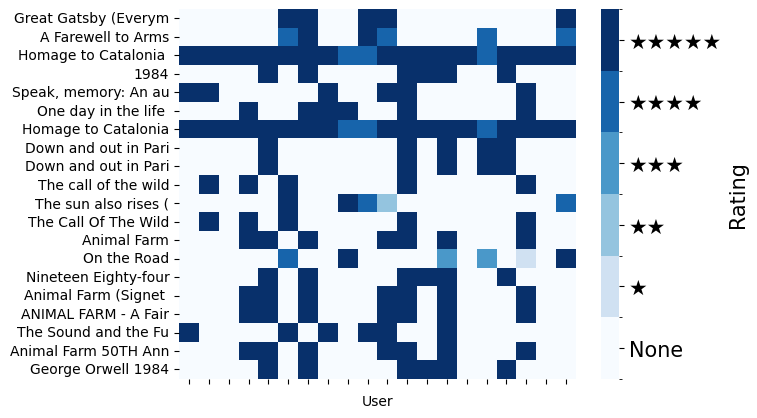

In [106]:

import matplotlib as mpl

user_ratings_per_product.fillna(fill_value, inplace = True)
plot_user_ratings_by_product(user_ratings_per_product, product.id, conn)

### Create Pairwise Similarity table

For each pair of products/rows in teh above rating map, find the similarity between the two rows. Output the pairwise similarities in a matrix:

In [32]:
user_ratings_per_product_sparse = sparse.csr_matrix(user_ratings_per_product.fillna(fill_value))
pairwise_cosine_similarities = pairwise_distances(user_ratings_per_product_sparse, metric = 'cosine')
user_ratings_per_product_sparse
pairwise_cosine_similarities = pd.DataFrame(pairwise_cosine_similarities, index = user_ratings_per_product.index, columns = user_ratings_per_product.index)
pairwise_cosine_similarities

product_id,0141803738,0486417786,0786102985,B0006P8SZI,B0006VUFO4,B0007BY9UY,B000EHHOVC,B000GROPF8,B000JQXNSQ,B000N79NHQ
product_id,,,,,,,,,,
0141803738,0.000000,0.711325,3.792478e-01,0.741801,0.845081,3.792478e-01,8.450807e-01,8.450807e-01,8.450807e-01,8.450807e-01
0486417786,0.711325,0.000000,3.675445e-01,0.329180,0.329180,3.675445e-01,3.291796e-01,3.291796e-01,3.291796e-01,3.291796e-01
0786102985,0.379248,0.367544,0.000000e+00,0.292893,0.292893,1.110223e-16,2.928932e-01,2.928932e-01,2.928932e-01,2.928932e-01
B0006P8SZI,0.741801,0.329180,2.928932e-01,0.000000,0.400000,2.928932e-01,4.000000e-01,4.000000e-01,4.000000e-01,4.000000e-01
B0006VUFO4,0.845081,0.329180,2.928932e-01,0.400000,0.000000,2.928932e-01,2.000000e-01,2.000000e-01,2.000000e-01,2.000000e-01
B0007BY9UY,0.379248,0.367544,1.110223e-16,0.292893,0.292893,0.000000e+00,2.928932e-01,2.928932e-01,2.928932e-01,2.928932e-01
B000EHHOVC,0.845081,0.329180,2.928932e-01,0.400000,0.200000,2.928932e-01,0.000000e+00,1.110223e-16,1.110223e-16,1.110223e-16
B000GROPF8,0.845081,0.329180,2.928932e-01,0.400000,0.200000,2.928932e-01,1.110223e-16,0.000000e+00,1.110223e-16,1.110223e-16
B000JQXNSQ,0.845081,0.329180,2.928932e-01,0.400000,0.200000,2.928932e-01,1.110223e-16,1.110223e-16,0.000000e+00,1.110223e-16


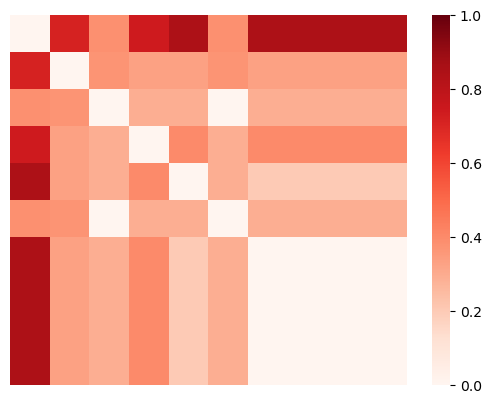

In [33]:
def plot_pairwise_similarities(data: pd.DataFrame, id: str, conn):
    sns.heatmap(data, vmin = 0, vmax = 1, cmap = 'Reds')
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plot_pairwise_similarities(pairwise_cosine_similarities, product.id, conn)    

In [34]:
recommendations = pairwise_cosine_similarities.loc[product.id]
recommendations

product_id
0141803738    3.792478e-01
0486417786    3.675445e-01
0786102985    0.000000e+00
B0006P8SZI    2.928932e-01
B0006VUFO4    2.928932e-01
B0007BY9UY    1.110223e-16
B000EHHOVC    2.928932e-01
B000GROPF8    2.928932e-01
B000JQXNSQ    2.928932e-01
B000N79NHQ    2.928932e-01
Name: 0786102985, dtype: float64

<Axes: >

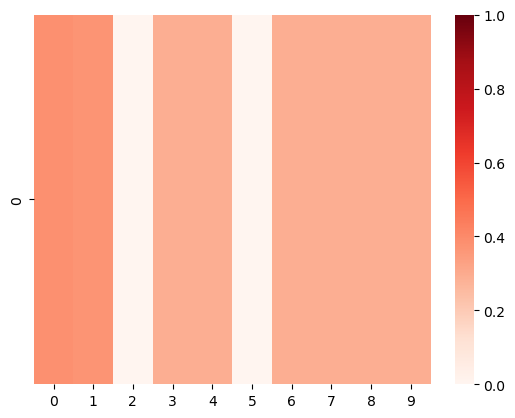

In [35]:
sns.heatmap([recommendations], vmin = 0, vmax = 1, cmap = 'Reds')


<Axes: xlabel='0786102985', ylabel='Count'>

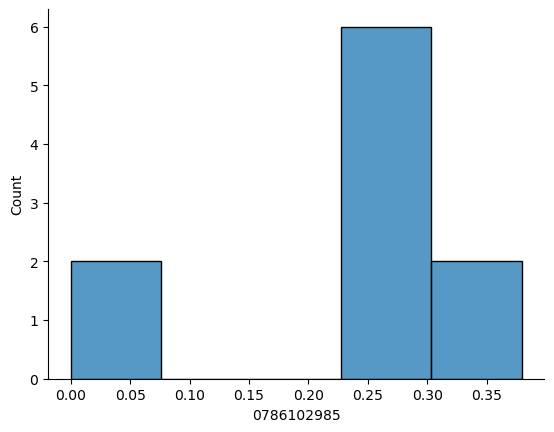

In [36]:
sns.histplot(recommendations)

In [37]:
results = q.get_recommendations_from_reviews(product.id, related_reviews, conn)
results

0.00295: Created ratings table for 10 products by 10 users
0.00432: Calculated similarities
0.00797: Added product details


,similarity,title,creator,publisher,description,category,subcategory,release_date
B0007BY9UY,1.000000,Homage to Catalonia,George Orwell,Pan Macmillan,Homage to Catalonia remains one of the most fa...,Books,Biography & Autobiography,2021-03-04
B0006P8SZI,0.707107,"Speak, memory: An autobiography revisited",nan,None,None,Books,nan,None
B0006VUFO4,0.707107,One day in the life of Ivan Denisovich (Praege...,Александр Исаевич Солженицын,None,None,Books,nan,1963
B000EHHOVC,0.707107,Animal Farm,nan,None,None,Books,nan,None
B000GROPF8,0.707107,"Animal Farm (Signet Classics, CT304)",nan,None,None,Books,nan,1966-03
B000JQXNSQ,0.707107,ANIMAL FARM - A Fairy Story (Time Reading Prog...,Gillian Fenwick,Oak Knoll Press,None,Books,Biography & Autobiography,1998
B000N79NHQ,0.707107,Animal Farm 50TH Anniversary Edition,George Orwell,Houghton Mifflin Harcourt,A satire on totalitarianism in which farm anim...,Books,Fiction,1995
0486417786,0.632456,The Call of the Wild (Dover Large Print Classics),Jack London,Courier Corporation,"The adventures of an unusual dog, part St. Ber...",Books,Fiction,2001-05-01
0141803738,0.620752,Thin Man (Classic Crime),Dashiell Hammett,None,None,Books,"Charles, Nick (Fictitious character)",1932
